# Part 1: Data Acquisition & Preprocessing

**Objective**: Acquire and preprocess S&P 500 stock price data for portfolio analysis.

**Key Tasks**:
1. Scrape top 100 S&P 500 tickers by market capitalization
2. Download 5 years of End-of-Day OHLCV data
3. Clean and align data to uniform trading calendar
4. Compute daily log returns

**Deliverables**:
- `prices`: Adjusted close price matrix (DataFrame)
- `log_returns`: Daily log returns matrix (DataFrame)
- Complete code workflow for data acquisition and preprocessing

In [7]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## Task 1: Scrape Top 100 S&P 500 Tickers by Market Cap

In [8]:
# Get S&P 500 tickers from Wikipedia and select top 100 by market cap
def get_sp500_tickers():
    """Scrape S&P 500 tickers from Wikipedia"""
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    tables = pd.read_html(url)
    sp500_table = tables[0]
    tickers = sp500_table['Symbol'].str.replace('.', '-').tolist()
    return tickers

# Get all S&P 500 tickers
sp500_tickers = get_sp500_tickers()
print(f"Found {len(sp500_tickers)} S&P 500 tickers")

# Get market caps to select top 100
print("Getting market capitalizations...")
market_caps = {}

# Process efficiently - check first 150 tickers
for ticker in sp500_tickers[:150]:
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        market_cap = info.get('marketCap', 0)
        if market_cap > 0:
            market_caps[ticker] = market_cap
    except:
        continue

# Sort by market cap and get top 100
sorted_tickers = sorted(market_caps.items(), key=lambda x: x[1], reverse=True)
top_100_tickers = [ticker for ticker, _ in sorted_tickers[:100]]

print(f"✓ Selected top 100 tickers by market cap")
print(f"Sample tickers: {top_100_tickers[:5]}..." +
      f"{top_100_tickers[-5:]}")
print(f"Total: {len(top_100_tickers)} tickers")

Found 503 S&P 500 tickers
Getting market capitalizations...
✓ Selected top 100 tickers by market cap
Sample tickers: ['AAPL', 'AMZN', 'GOOGL', 'GOOG', 'AVGO']...['DXCM', 'AWK', 'ADM', 'AEE', 'AVB']
Total: 100 tickers


## Task 2: Download EOD OHLCV Data (5 Years)

In [9]:
# Download 5 years of EOD OHLCV data

# Define date range
end_date = "2025-08-07"  # Use today's date
start_date = "2020-08-07"

print(f"Downloading data from {start_date} to " +
      f"{end_date} for {len(top_100_tickers)} tickers...")
# Download data for all tickers
raw_data = yf.download(
    tickers=top_100_tickers,
    start=start_date,
    end=end_date,
    group_by='ticker',
    auto_adjust=True,
    prepost=False,
    threads=True
)

print(f"✓ Download completed!")
print(f"Data shape: {raw_data.shape}")
print(f"Date range: {raw_data.index[0]} to {raw_data.index[-1]}")

# Display first 5 rows of raw data
print("Displaying first 5 rows of raw data:")
print(raw_data.head(5))

[*********************100%***********************]  100 of 100 completed

✓ Download completed!
Data shape: (1255, 500)
Date range: 2020-08-07 00:00:00 to 2025-08-06 00:00:00
Displaying first 5 rows of raw data:
Ticker          CMG                                                  GOOG  \
Price          Open       High        Low      Close    Volume       Open   
Date                                                                        
2020-08-07  23.6394  23.865000  23.181400  23.612400  11600000  74.556821   
2020-08-10  23.6122  23.770599  22.659401  23.219999  15235000  73.919605   
2020-08-11  23.2952  23.440001  22.824400  22.943199  11175000  74.181058   
2020-08-12  23.1600  23.375000  23.056801  23.218399   7830000  73.840079   
2020-08-13  23.4200  23.953800  23.346001  23.898600  13135000  75.070763   

Ticker                                                 ...        ALL  \
Price            High        Low      Close    Volume  ...       Open   
Date                                                   ...              
2020-08-07  75.394091  73.

## Task 3: Clean and Align Data to Uniform Calendar

Extracting and cleaning adjusted close prices...
Cleaning data...
✓ Clean price data: 1255 dates × 100 tickers
Date range: 2020-08-07 00:00:00 to 2025-08-06 00:00:00
Final tickers count: 100
Displaying first 5 rows of the cleaned price data:
                  AAPL        AMZN      GOOGL       GOOG       AVGO  \
Date                                                                  
2020-08-07  108.203766  158.373001  74.471870  74.282951  28.915098   
2020-08-10  109.776497  157.408005  74.394829  74.362968  29.041958   
2020-08-11  106.511757  154.033493  73.585686  73.578636  28.746540   
2020-08-12  110.051590  158.112000  74.912727  74.885864  29.599091   
2020-08-13  111.999229  158.050995  75.380409  75.473869  29.224718   

                 BRK-B        COST       ABBV        BAC        CVX  ...  \
Date                                                                 ...   
2020-08-07  209.479996  314.168182  75.978493  23.083559  69.710854  ...   
2020-08-10  212.580002  313.3294

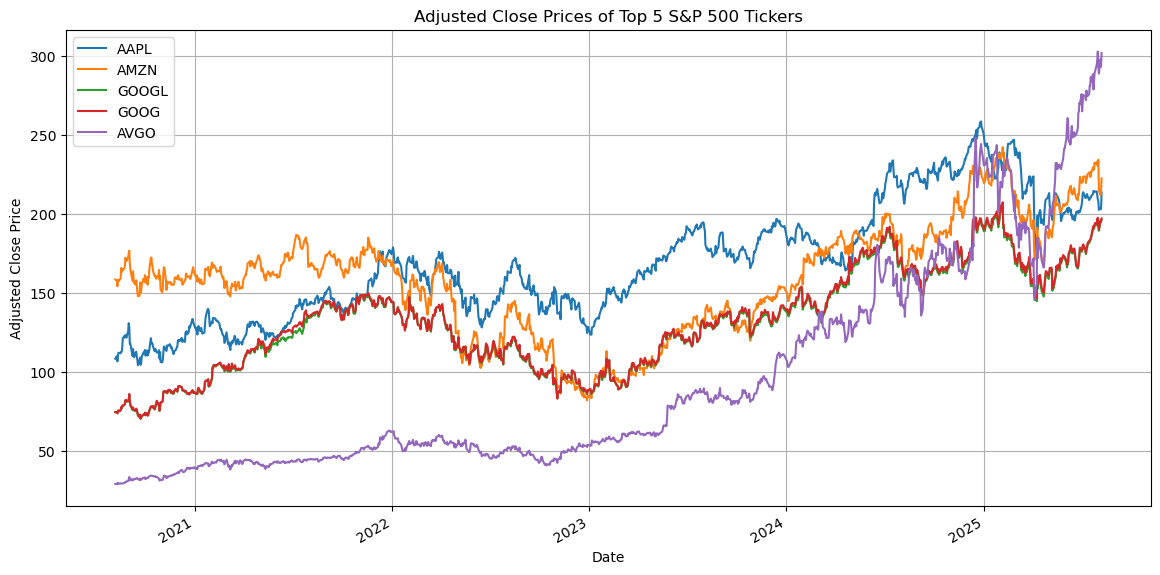

In [10]:
# Extract and clean adjusted close prices
print("Extracting and cleaning adjusted close prices...")

# Extract close prices for all tickers
if len(top_100_tickers) == 1:
    # Single ticker case
    prices = raw_data[['Close']].copy()
    prices.columns = top_100_tickers
else:
    # Multiple tickers case
    prices = pd.DataFrame(index=raw_data.index)
    for ticker in top_100_tickers:
        if ticker in raw_data.columns.get_level_values(0):
            prices[ticker] = raw_data[ticker]['Close']

# Clean the data
print("Cleaning data...")
# Remove columns with all NaN values
prices = prices.dropna(axis=1, how='all')
# Remove rows with all NaN values
prices = prices.dropna(how='all')
# Forward fill missing values
prices = prices.fillna(method='ffill')
# Backward fill remaining NaN values
prices = prices.fillna(method='bfill')

final_tickers = prices.columns.tolist()
print(f"✓ Clean price data: {prices.shape[0]} dates × " +
      f"{prices.shape[1]} tickers")
print(f"Date range: {prices.index[0]} to {prices.index[-1]}")
print(f"Final tickers count: {len(final_tickers)}")

# Display uniformly formatted output
print("Displaying first 5 rows of the cleaned price data:")
print(prices.head(5))

# Plot the first 5 tickers to visualize the data
print("Plotting first 5 tickers...")
prices.iloc[:, :5].plot(figsize=(14, 7))
plt.title('Adjusted Close Prices of Top 5 S&P 500 Tickers')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend(loc='upper left')
plt.grid()
plt.show()

## Task 4: Compute Daily Log Returns

Formula: r_t = ln(P_t / P_{t-1}) = ln(P_t) - ln(P_{t-1})

Computing daily log returns...
✓ Log returns computed successfully!
Shape: (1254, 100)
Date range: 2020-08-10 00:00:00 to 2025-08-06 00:00:00

Summary statistics:
Mean daily return: 0.000567
Std daily return: 0.019338
Data quality - NaN values: 0
Data quality - Infinite values: 0
Displaying first 5 rows of log returns:
                AAPL      AMZN     GOOGL      GOOG      AVGO     BRK-B  \
Date                                                                     
2020-08-10  0.014430 -0.006112 -0.001035  0.001077  0.004378  0.014690   
2020-08-11 -0.030191 -0.021671 -0.010936 -0.010603 -0.010224  0.000376   
2020-08-12  0.032694  0.026134  0.017873  0.017610  0.029226  0.002724   
2020-08-13  0.017543 -0.000386  0.006224  0.007821 -0.012729 -0.005926   
2020-08-14 -0.000891 -0.004121 -0.007957 -0.007085 -0.004869 -0.004823   

                COST      ABBV       BAC       CVX  ...      ACGL         A  \
Date                                                ...                       
20

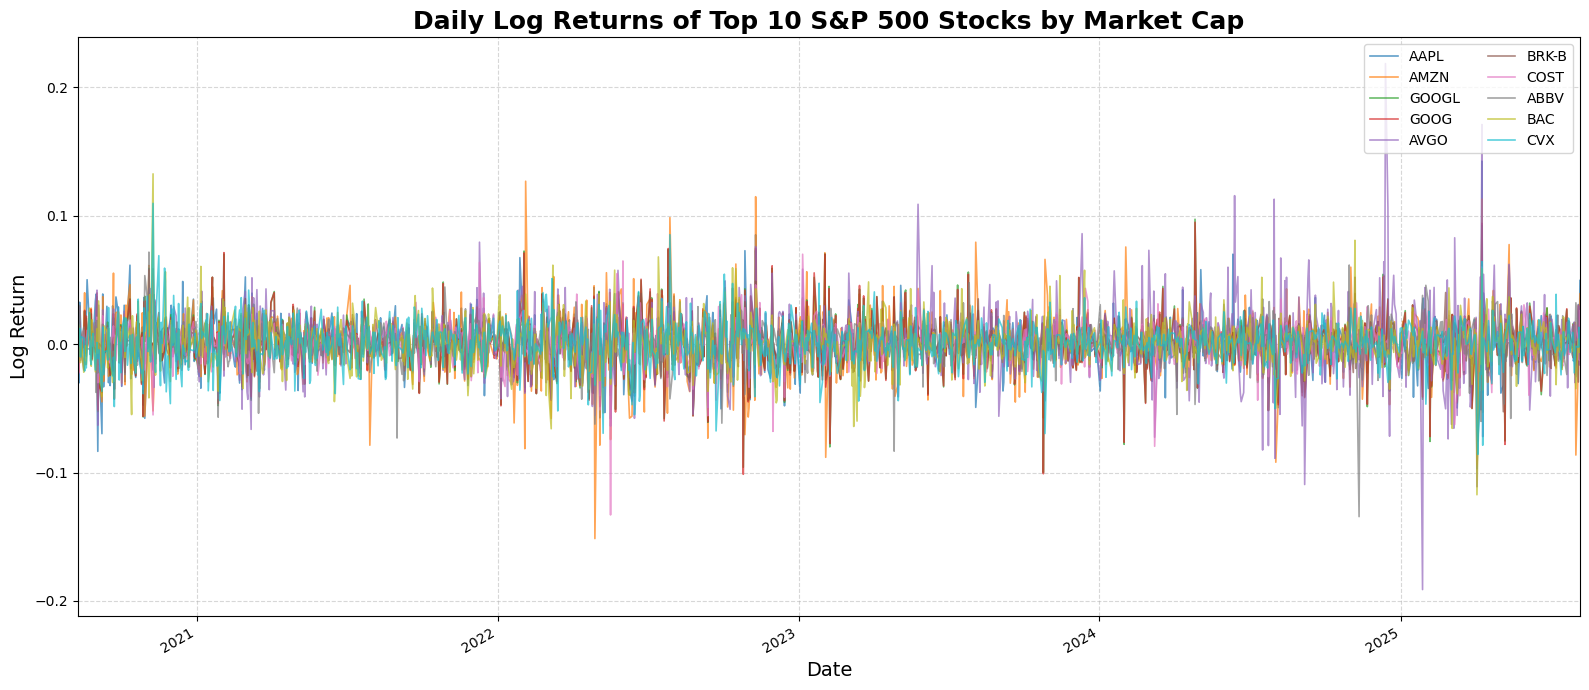

In [11]:
# Compute daily log returns: r_t = ln(P_t / P_{t-1})
print("Computing daily log returns...")

log_returns = np.log(prices / prices.shift(1))
log_returns = log_returns.dropna()

# Clean any infinite or NaN values
log_returns.replace([np.inf, -np.inf], np.nan, inplace=True)
log_returns.fillna(method='ffill', inplace=True)
log_returns.fillna(0, inplace=True)

print(f"✓ Log returns computed successfully!")
print(f"Shape: {log_returns.shape}")
print(f"Date range: {log_returns.index[0]} to {log_returns.index[-1]}")

# Basic statistics
print(f"\nSummary statistics:")
print(f"Mean daily return: {log_returns.mean().mean():.6f}")
print(f"Std daily return: {log_returns.std().mean():.6f}")
print(f"Data quality - NaN values: {log_returns.isnull().sum().sum()}")
print(f"Data quality - Infinite values: {np.isinf(log_returns).sum().sum()}")

# Display first 5 rows of log returns
print("Displaying first 5 rows of log returns:")
print(log_returns.head(5))

# Plot log returns: cleaner and more informative visualization
import matplotlib.dates as mdates

plt.figure(figsize=(16, 7))
# Plot only a subset of tickers for clarity (e.g., top 10 by market cap)
top10 = [ticker for ticker in top_100_tickers[:10] if ticker in log_returns.columns]
log_returns[top10].plot(ax=plt.gca(), alpha=0.7, linewidth=1.2)

plt.title('Daily Log Returns of Top 10 S&P 500 Stocks by Market Cap', 
          fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Log Return', fontsize=14)
plt.legend(top10, loc='upper right', ncol=2, fontsize=10, 
           frameon=True)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xlim(log_returns.index[0], log_returns.index[-1])
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

## Deliverables

In [12]:
# DELIVERABLE 1: prices - Adjusted close price matrix (DataFrame)
print("DELIVERABLE 1: prices")
print("=" * 40)
print(f"Type: {type(prices)}")
print(f"Shape: {prices.shape}")
print(f"Index: {prices.index[0]} to {prices.index[-1]}")
print(f"Columns: {len(prices.columns)} tickers")
print("\nSample data (first 5 rows, first 5 columns):")
display(prices.iloc[:5, :5])

print("\n" + "=" * 40)

# DELIVERABLE 2: log_returns - Daily log returns matrix (DataFrame) 
print("DELIVERABLE 2: log_returns")
print("=" * 40)
print(f"Type: {type(log_returns)}")
print(f"Shape: {log_returns.shape}")
print(f"Index: {log_returns.index[0]} to {log_returns.index[-1]}")
print(f"Columns: {len(log_returns.columns)} tickers")
print(f"Formula: r_t = ln(P_t / P_{{t-1}})")
print("\nSample data (first 5 rows, first 5 columns):")
display(log_returns.iloc[:5, :5])

print("\n" + "=" * 40)

# DELIVERABLE 3: This notebook - Data preprocessing script
print("DELIVERABLE 3: This notebook")
print("=" * 40)
print("Type: Jupyter Notebook (.ipynb)")
print("Contains all code and comments for data acquisition " +
      "and preprocessing")

DELIVERABLE 1: prices
Type: <class 'pandas.core.frame.DataFrame'>
Shape: (1255, 100)
Index: 2020-08-07 00:00:00 to 2025-08-06 00:00:00
Columns: 100 tickers

Sample data (first 5 rows, first 5 columns):


,AAPL,AMZN,GOOGL,GOOG,AVGO
Date,,,,,
2020-08-07,108.203766,158.373001,74.471870,74.282951,28.915098
2020-08-10,109.776497,157.408005,74.394829,74.362968,29.041958
2020-08-11,106.511757,154.033493,73.585686,73.578636,28.746540
2020-08-12,110.051590,158.112000,74.912727,74.885864,29.599091
2020-08-13,111.999229,158.050995,75.380409,75.473869,29.224718



DELIVERABLE 2: log_returns
Type: <class 'pandas.core.frame.DataFrame'>
Shape: (1254, 100)
Index: 2020-08-10 00:00:00 to 2025-08-06 00:00:00
Columns: 100 tickers
Formula: r_t = ln(P_t / P_{t-1})

Sample data (first 5 rows, first 5 columns):


,AAPL,AMZN,GOOGL,GOOG,AVGO
Date,,,,,
2020-08-10,0.014430,-0.006112,-0.001035,0.001077,0.004378
2020-08-11,-0.030191,-0.021671,-0.010936,-0.010603,-0.010224
2020-08-12,0.032694,0.026134,0.017873,0.017610,0.029226
2020-08-13,0.017543,-0.000386,0.006224,0.007821,-0.012729
2020-08-14,-0.000891,-0.004121,-0.007957,-0.007085,-0.004869



DELIVERABLE 3: This notebook
Type: Jupyter Notebook (.ipynb)
Contains all code and comments for data acquisition and preprocessing
